# Main anaysis

### Setup

#### Imports

In [305]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

#### Overrides

In [306]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma='log10(0.5)'",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.imprecise_imitation_gamma='np.log(0.5)'",
    "simulation.dynamics.max_its=200", # important to specify maxits
    "seed=0",
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


#### Helper function to filter data by config data

In [307]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    imprecise_imitation_gamma = df["imprecise_imitation_gamma"].isin([curve_metadata.meaning_dist_gamma, np.nan]) # allows curve, and constraints to be the same as curve.

    # TODO: subset by max its in simulation
    max_its = df["max_its"].isin([config.simulation.dynamics.max_its, np.nan])# allows curve

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & imprecise_imitation_gamma & max_its]

    return df_subsetted

#### Load data

In [308]:
all_data_fp = "../../analysis_data/all_data.csv"
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_3582/1048885480.py:2: DtypeWarning: Columns (4,15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,kl_eb,min_gnid,gnid_beta,eu_gamma=0,eu_gamma=-3,eu_gamma=-1,eu_gamma=1,eu_gamma=2,eu_gamma=3,eu_gamma=log10(0.5)
0,1.526090e+00,1.270097,0.641931,2.278652,[0.0054146544510602634],0.012748,1.095495,0.0,simulation,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000e+00,0.000000,1.912028,16.399997,NaN,NaN,NaN,1.0,trajectory,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000e+00,0.000000,1.912028,16.330831,NaN,NaN,NaN,1.0,trajectory,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000e+00,0.000000,1.912028,16.278492,NaN,NaN,NaN,1.0,trajectory,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.881784e-16,0.000000,1.912028,16.236625,NaN,NaN,NaN,1.0,trajectory,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126152,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126153,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126154,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126155,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [309]:
df[df["meaning_dist_gamma"] == 'log10(0.5)'].discriminative_need_gamma.unique()

array(['0', '1', '-1', 'log10(0.5)', '-3', '3', 3.0, 2.0, -2.0, nan],
      dtype=object)

#### Filter

In [310]:
df = get_df_subsetted_by_meaning_dists(df, config)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,kl_eb,min_gnid,gnid_beta,eu_gamma=0,eu_gamma=-3,eu_gamma=-1,eu_gamma=1,eu_gamma=2,eu_gamma=3,eu_gamma=log10(0.5)
107902,4.047090,3.788592,34.874486,6.264927,NaN,NaN,NaN,0.0,simulation,NaN,...,0.044794,0.000218,1.451759,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107903,0.272999,0.068292,3.234820,1669.606551,NaN,NaN,NaN,1.0,trajectory,1.0,...,0.346019,0.951718,1.000758,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107904,0.090155,0.073613,3.246071,1653.288101,NaN,NaN,NaN,1.0,trajectory,2.0,...,0.003725,0.846531,1.000707,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107905,0.224554,0.201004,3.336560,1623.580970,NaN,NaN,NaN,1.0,trajectory,3.0,...,0.003046,0.762136,1.000859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107906,0.607634,0.562027,3.613586,1524.930465,NaN,NaN,NaN,1.0,trajectory,4.0,...,0.004754,0.712696,1.001061,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126152,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126153,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126154,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126155,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [311]:
df[df["meaning_dist_gamma"] == 'log10(0.5)'].discriminative_need_gamma.value_counts()

discriminative_need_gamma
0             1351
1             1351
-1            1351
log10(0.5)    1351
-3            1351
2.0           1351
-2.0          1351
3.0           1320
3               31
Name: count, dtype: int64

todo: missing data might be because max_its gets overwritten, we don't actually organize folders hierarchically with it (maybe we should). So for now just plan on running all of those sims.

In [312]:
# Edge cases where discriminative_need_gamma and meaning_dist_gamma are str types
for col in [
    "discriminative_need_gamma",
    "meaning_dist_gamma",
    "imprecise_imitation_gamma",
]:
    df[col].replace("log10(0.5)", np.log10(0.5), inplace=True)
    df[col] = df[col].astype(float)

Separate out observations into curves and simulation points

In [313]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

Transform log params

In [314]:
df_final_points["discriminative_need_gamma"] = 10 ** df_final_points["discriminative_need_gamma"]
df_final_points["imprecise_imitation_gamma"] = 10 ** df_final_points["imprecise_imitation_gamma"]

Restrict dynamics

In [315]:
df_final_points = df_final_points[df_final_points["dynamics"] == "imprecise_conditional_imitation"]

How does discriminative_need_gamma range?

In [316]:
df_final_points.discriminative_need_gamma.unique()

array([1.e+00, 1.e+01, 1.e-01, 5.e-01, 1.e-03, 1.e+03, 1.e+02, 1.e-02])

In [317]:
# How does seed range?
df_final_points.seed.unique()

array([6., 1., 0., 2., 5., 4., 3.])

In [318]:
# Remember, popuation_init_gamma is nan if we go with the simple uniform sampling init
df_final_points.population_init_gamma.unique()

array([nan])

### Visualize

In [319]:
# Make sure complexity max is np.log2(100)
assert np.allclose(df_ib_bound.complexity.max().item(), np.log2(100))

#### First visualize all data, across initializations and seeds

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


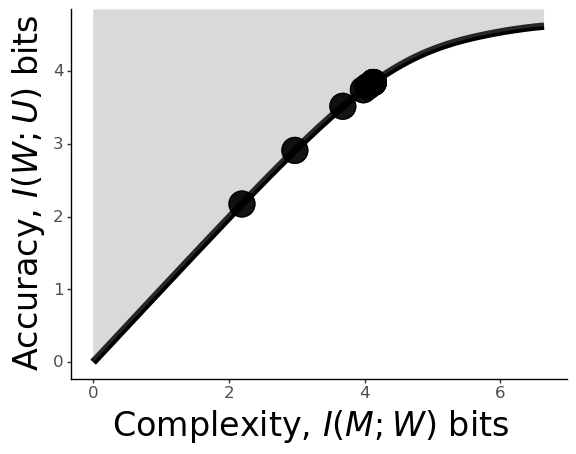

In [320]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # shape="seed",
            ),
        alpha=0.3,
        size=10,
    )
    + pn.labs(fill="$\\gamma$ (pragmatic precision)")
    # + pn.labs(fill="$\\alpha$ (perceptual certainty)")    
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    ) 
)
print(plot)

#### Hack: mock viridis

In [321]:
# https://waldyrious.net/viridis-palette-generator/
fill_values_dict = {
    str(k): v for k, v in {
        "0.001": "#440154",
        "0.01": "#46327e",
        "0.1": "#365c8d",
        "0.5": "#277f8e",
        "1.0": "#1fa187",
        "10.0": "#4ac16d",
        "100.0" : "#a0da39",
        "1000.0": "#fde725", 
    }.items() }

In [322]:
# Double check no min_epsilons are negative
df_final_points[df_final_points.min_epsilon < 0]

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,kl_eb,min_gnid,gnid_beta,eu_gamma=0,eu_gamma=-3,eu_gamma=-1,eu_gamma=1,eu_gamma=2,eu_gamma=3,eu_gamma=log10(0.5)


#### Distribution of efficiency loss across converged emergent systems

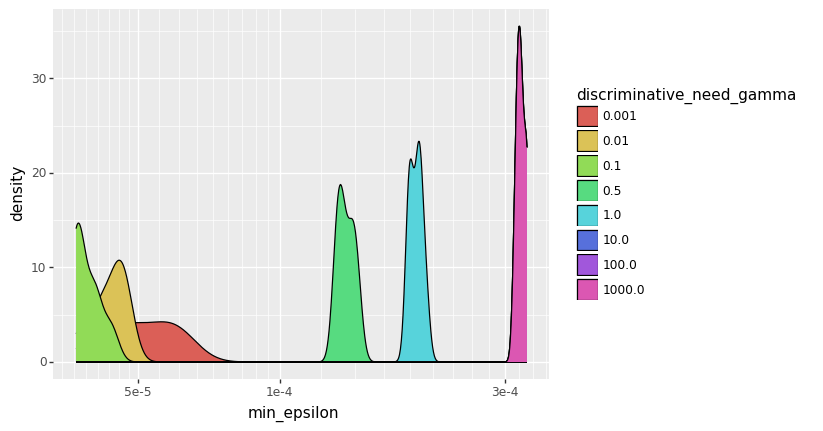

<ggplot: (391191519)>

In [323]:
df_final_points_disc = df_final_points.copy()
df_final_points_disc["discriminative_need_gamma"] = df_final_points_disc["discriminative_need_gamma"].astype(str)
df_final_points_disc["seed"] = df_final_points_disc["seed"].astype(int).astype(str)

(
    pn.ggplot(
        df_final_points_disc,
        pn.aes(
            x="min_epsilon",
            # fill="seed",
            fill="discriminative_need_gamma",
        )
    )
    # + pn.scale_fill_manual(values = fill_values_dict)
    + pn.geom_density()
    # + pn.geom_histogram(binwidth=0.01)
    + pn.scale_x_log10()
    # + pn.facet_wrap("discriminative_need_gamma")
)

# Okay, so for the first random seed I picked, the distribution of efficiency loss is highly peaked. This makes some sense, because if we look at the the trajectories, all colors appear to converge to the same respective points on y-axis.

#### Trajectories of efficiency loss

Filter

In [324]:
gamma = 'discriminative_need_gamma'

df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["round"]

df_traj_analysis = df_traj_points.copy()

df_traj_analysis = df_traj_analysis[["iteration", "min_distance_to_curve", "min_epsilon", "min_beta", gamma, "population_init_gamma", "complexity", "accuracy", "seed", "kl_eb", "eu_gamma", "min_gnid", "gnid_beta",]]

# seed shoud be discrete
df_traj_analysis["seed"] = df_traj_analysis["seed"].astype(int).astype(str)

df_traj_analysis[gamma] = 10 ** df_traj_analysis[gamma]
df_traj_analysis["population_init_gamma"] = 10 ** df_traj_analysis["population_init_gamma"]

df_traj_analysis["discriminative_need_gamma"] = df_traj_analysis["discriminative_need_gamma"].astype(str)

df_traj_analysis

,iteration,min_distance_to_curve,min_epsilon,min_beta,discriminative_need_gamma,population_init_gamma,complexity,accuracy,seed,kl_eb,eu_gamma,min_gnid,gnid_beta
107903,1.0,0.146229,0.204422,1.001313,1.0,NaN,0.272999,0.068292,6,0.346019,0.017679,0.951718,1.000758
107904,2.0,0.017502,0.016472,1.001010,1.0,NaN,0.090155,0.073613,6,0.003725,0.019376,0.846531,1.000707
107905,3.0,0.018380,0.023327,1.001263,1.0,NaN,0.224554,0.201004,6,0.003046,0.022664,0.762136,1.000859
107906,4.0,0.032033,0.044749,1.002424,1.0,NaN,0.607634,0.562027,6,0.004754,0.033976,0.712696,1.001061
107907,5.0,0.059218,0.083306,1.010556,1.0,NaN,1.483390,1.394361,6,0.012761,0.072413,0.596020,1.002828
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118704,195.0,0.001444,0.000046,1.097538,0.01,NaN,2.972019,2.910366,3,0.005543,0.836928,0.000139,1.097538
118705,197.0,0.001449,0.000046,1.097538,0.01,NaN,2.972015,2.910363,3,0.005542,0.836928,0.000138,1.097538
118706,198.0,0.001451,0.000046,1.097538,0.01,NaN,2.972014,2.910361,3,0.005542,0.836928,0.000138,1.097538
118707,199.0,0.001453,0.000046,1.097538,0.01,NaN,2.972012,2.910360,3,0.005542,0.836928,0.000138,1.097538


In [325]:
# Ensure iteration max is the same as max_its specified by game config
df_traj_analysis.iteration.max()

200.0

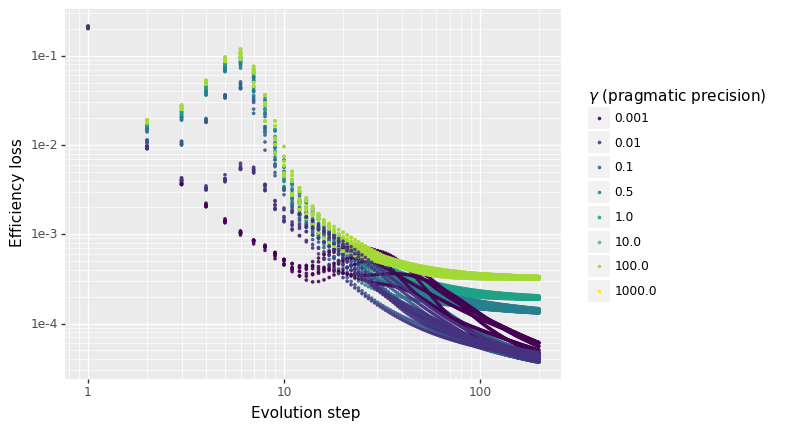

In [326]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_epsilon", 
            color="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    # + pn.geom_line()
    + pn.scale_color_manual(values = fill_values_dict)
    + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("Efficiency loss")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

In [327]:
# temp save for R exploration
df_traj_analysis.to_csv("df_traj_analysis.csv", index=False)

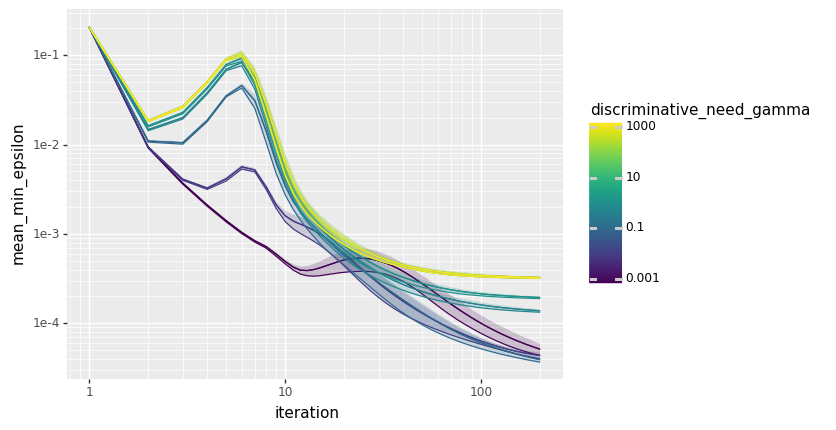

<ggplot: (351274474)>

In [328]:
from scipy import stats


# Calculate the mean and confidence intervals for each iteration
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

df_summary = df_traj_analysis.groupby(['iteration', 'discriminative_need_gamma'])['min_epsilon'].apply(mean_confidence_interval).apply(pd.Series)
df_summary.columns = ['mean_min_epsilon', 'lower_ci', 'upper_ci']
df_summary = df_summary.reset_index()

# convert gamma to numeric
df_summary["discriminative_need_gamma"] = df_summary["discriminative_need_gamma"].astype(float)

(
   pn.ggplot(
      df_summary,
      pn.aes(
         x="iteration",
         y="mean_min_epsilon",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 701 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1309 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1309 rows containing missing values.


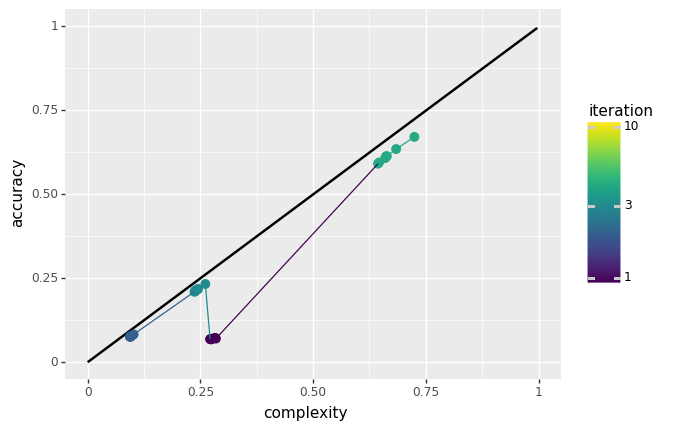

<ggplot: (391179721)>

In [329]:
# I'm so curious to see if we can see this on the trajectories. Zoom in on gamma=1000

df_traj_gamma_3 = df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == '1000.0']

(
    pn.ggplot(
        df_traj_gamma_3,
        pn.aes(
            x="complexity",
            y="accuracy",
            color="iteration",
        ),
    )
    + pn.scale_color_continuous(trans = "log10", limits=[1,10])
    + pn.geom_line(df_ib_bound, size=1, color="black")
    + pn.geom_point(size=3)
    + pn.geom_line()
    + pn.ylim(0,1)
    + pn.xlim(0,1)
)

#### Visualize comp vs. EU

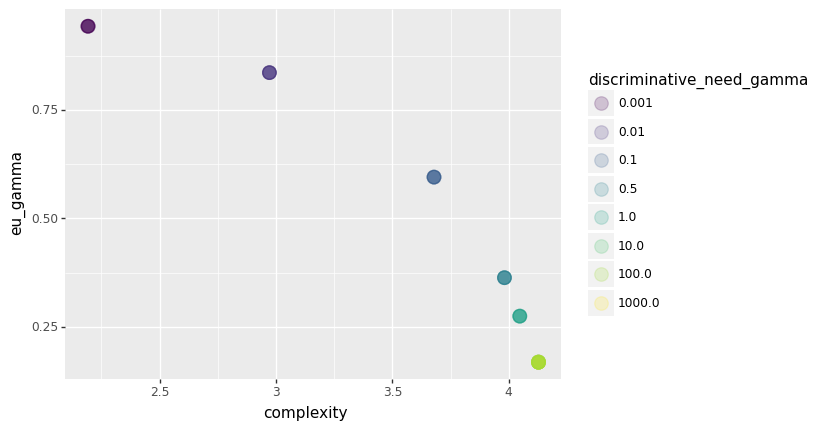

<ggplot: (807407232)>

In [330]:
(
    pn.ggplot(
        df_final_points_disc,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_manual(values = fill_values_dict)
    + pn.geom_point(size=5, alpha=0.2)
    # + pn.facet_wrap("seed")
)

In [333]:
# I'd like to know what the IB curves achieve in terms of their EU.

eu_cols = [colname for colname in df_ib_bound.columns if "eu_gamma=" in colname]
cols = ["complexity", "accuracy",] + eu_cols


df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)

# Yet another bandaid for string parsing the 0.5 width.

df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1])
df_ib_eu["discriminative_need_gamma"] = 10 ** df_ib_eu["discriminative_need_gamma"].astype(float)
df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].astype(str)

# df_ib_eu

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_manual(values = fill_values_dict)
    + pn.geom_point()
)

ValueError: could not convert string to float: 'log10(0.5)'

together?

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 2155 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 35 rows containing missing values.


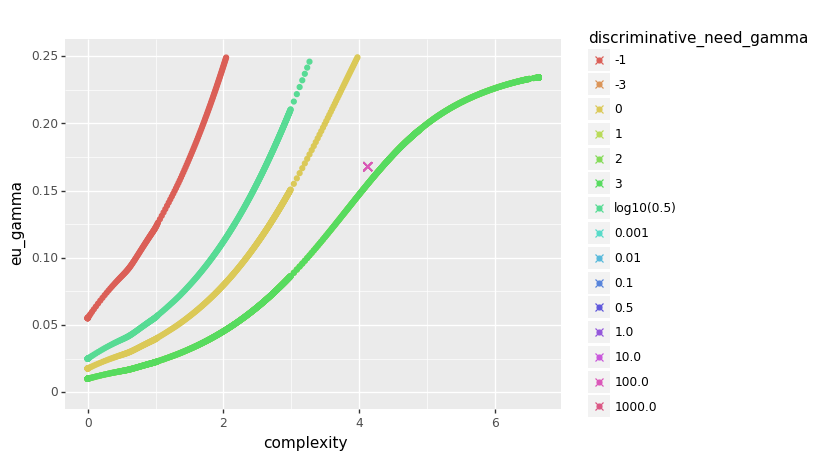

<ggplot: (378315512)>

In [332]:
(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_manual(values = fill_values_dict)
    + pn.geom_point(shape="o")

    # Now the simulation data
    + pn.geom_point(
        data=df_final_points_disc,
        shape="x",
        size=3,
    )
    # + pn.ylim(0, 0.25)
)

In [ ]:
# Sanity check that a bijective sender and bayesian receiver team will achieve at most 0.25 expected utility in the highest gamma game, because of the meaning confusion probabilities

game = Game.from_hydra(config)

encoder = np.eye(len(game.universe))
# decoder = encoder.T # not nec. ib
decoder = (encoder * game.prior[:, None]) / (encoder.T @ game.prior) @ game.meaning_dists

optimal_team = optimal_team = game.meaning_dists @ encoder @ decoder @ game.meaning_dists

# expected utility
np.sum(game.prior * (optimal_team * game.utility))


0.234280490227258

In [334]:
# check that without confusion we achieve 1.0 utility
np.sum(game.prior * (np.eye(len(game.universe)) * game.utility))

1.0

is it possible to view trajectories too?

yes. 

HOw to read the below plot: lines are ib optima, circles are trajectories of emergent systems.

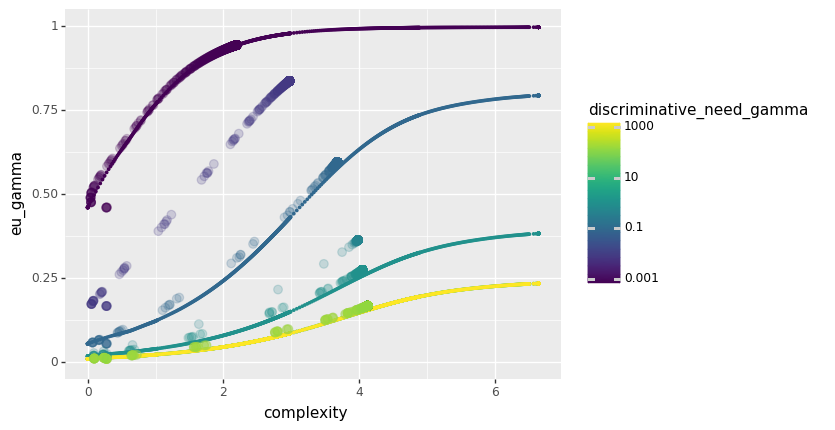

<ggplot: (381716051)>

In [ ]:
df_traj_temp = df_traj_analysis.copy()
df_traj_temp["discriminative_need_gamma"] = df_traj_temp["discriminative_need_gamma"].astype(float)

df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)
df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1])
df_ib_eu["discriminative_need_gamma"] = 10 ** df_ib_eu["discriminative_need_gamma"].astype(float)

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_continuous(trans = "log10")

    + pn.geom_point(
        # shape="o", 
        size=0.5,
    )

    # Now the simulation data
    + pn.geom_jitter(
        data=df_traj_temp,
        # data = df_traj_temp[df_traj_temp["discriminative_need_gamma"] == 1000], # why does the highest gamma always get overplotted? maybe we should drop anyway...
        mapping=pn.aes(
            # size="iteration",
        ),
        shape="o",
        size=3,
        alpha=0.2,
    )
    + pn.ylim(0,1)
)

,iteration,min_distance_to_curve,min_epsilon,min_beta,discriminative_need_gamma,population_init_gamma,complexity,accuracy,seed,kl_eb,eu_gamma,min_gnid,gnid_beta
114666,1.0,0.146229,0.204422,1.001313,1000.0,NaN,0.272999,0.068292,6,0.346019,0.010017,0.951718,1.000758
114667,2.0,0.014975,0.018856,1.001061,1000.0,NaN,0.095773,0.076841,6,0.003390,0.011060,0.846307,1.000758
114668,3.0,0.021393,0.027255,1.001263,1000.0,NaN,0.238784,0.211289,6,0.002842,0.013082,0.760693,1.000859
114669,4.0,0.037480,0.052274,1.002626,1000.0,NaN,0.644038,0.590814,6,0.005624,0.020187,0.713292,1.001111
114670,5.0,0.068925,0.096515,1.011818,1000.0,NaN,1.563615,1.460488,6,0.019936,0.044941,0.590093,1.003081
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116010,195.0,0.000347,0.000325,1.508040,1000.0,NaN,4.128144,3.843221,3,0.053781,0.167845,0.000409,1.508040
116011,197.0,0.000350,0.000325,1.508040,1000.0,NaN,4.128148,3.843224,3,0.053780,0.167845,0.000409,1.508040
116012,198.0,0.000352,0.000325,1.508040,1000.0,NaN,4.128151,3.843226,3,0.053780,0.167845,0.000408,1.508040
116013,199.0,0.000354,0.000325,1.508040,1000.0,NaN,4.128153,3.843227,3,0.053780,0.167845,0.000408,1.508040


#### Visualize kl_eb over time

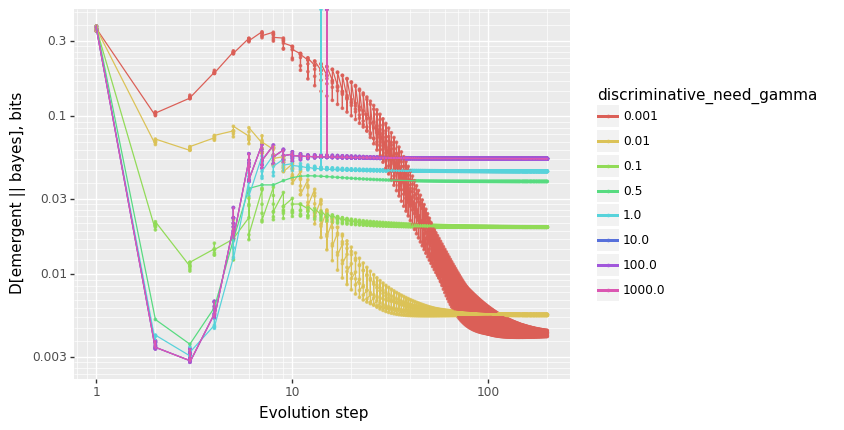

In [ ]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="kl_eb", 
            color="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("D[emergent || bayes], bits")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

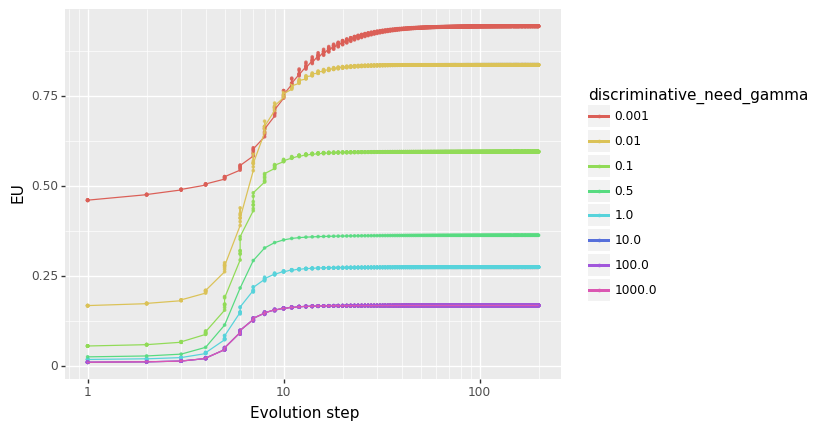

In [ ]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="eu_gamma", 
            color="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("EU")

    + pn.scale_y_continuous(
        # trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

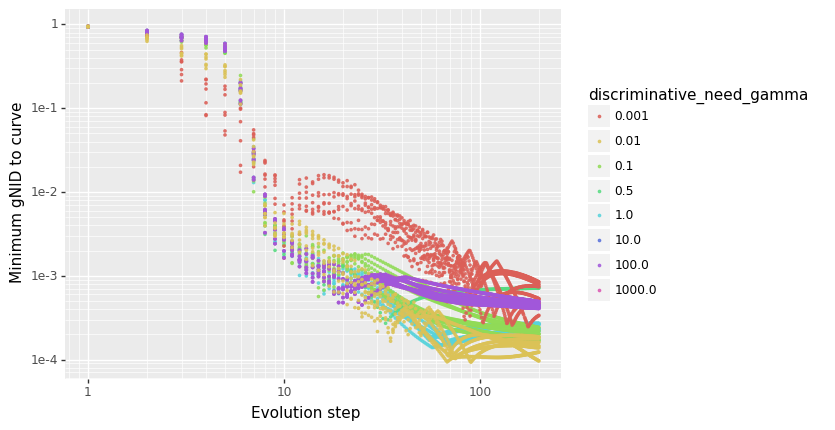

In [ ]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_gnid", 
            color="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    # + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("Minimum gNID to curve")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

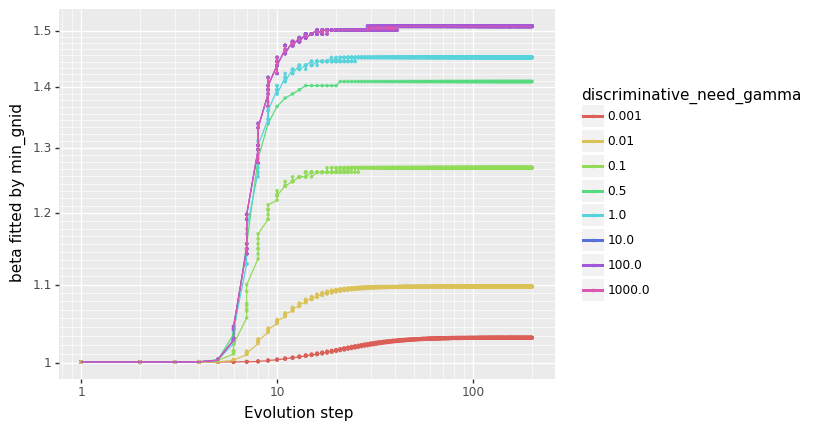

In [ ]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="gnid_beta", 
            color="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("beta fitted by min_gnid")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

N.B., this is different from beta fitted by min epsilon!

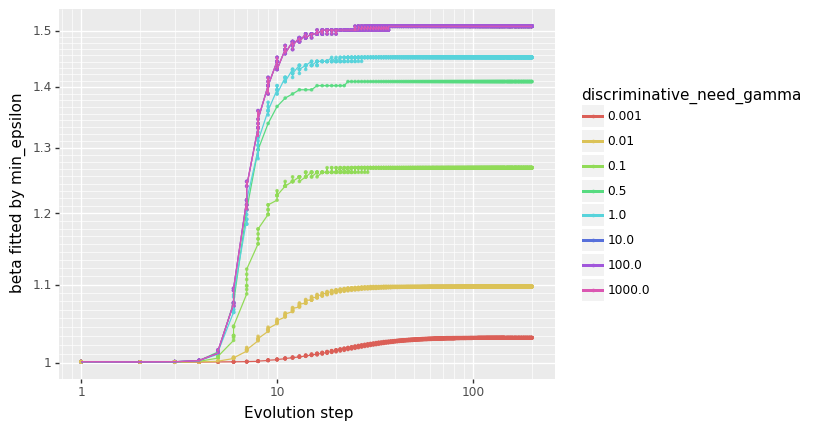

In [ ]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_beta", 
            color="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("beta fitted by min_epsilon")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

would be interesting to compare these betas, but i'll wait until someone asks